In [87]:
import numpy as np
import xarray as xr

import era5
from era5.util.util import format_bytes
from era5.maths.error import mae, rmse

%matplotlib inline

In [2]:
variable = era5.Temperature()

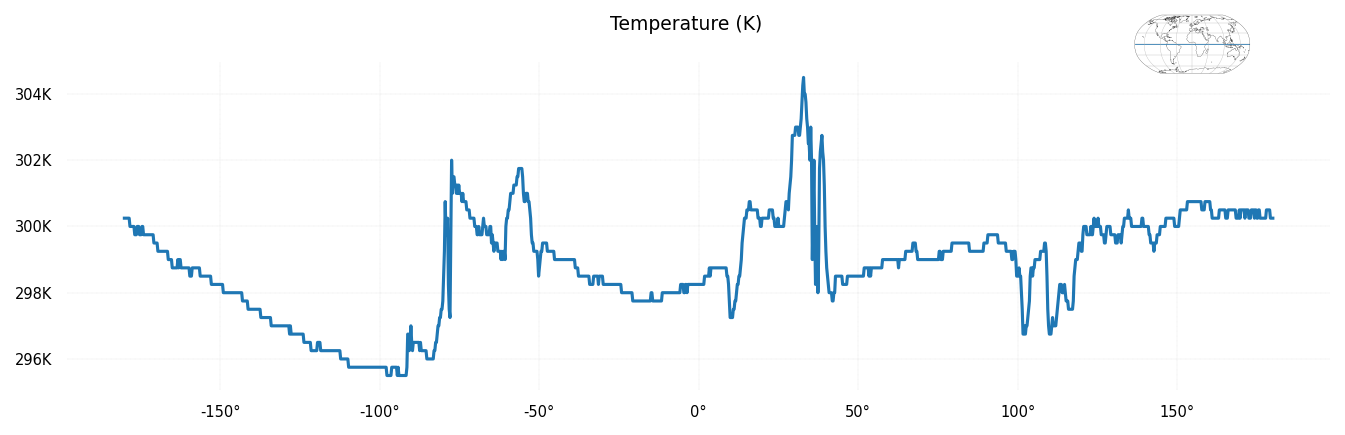

In [6]:
plot = era5.plot(variable, ["TAVG-01-01 00:00", 1000, 0])
plot.show()

In [123]:

class _FourierRegression:
    def __init__(self, data: np.ndarray | xr.Dataset, quantile: float = 0.75):
        if isinstance(data, xr.Dataset):
            data = data.to_dataarray().values.squeeze()
        self._data = data
            
        self._quantile = quantile
        self._inverted = None
        self._fft_idxs: np.ndarray = np.array([])
    
    def _fft(self) -> tuple[np.ndarray, np.ndarray]:
        _fft = np.fft.rfft(self._data)
        amplitudes = np.abs(_fft)

        cutoff_amp = np.quantile(amplitudes, self._quantile)
        mask = amplitudes > cutoff_amp
        return _fft[mask], mask

    def invert(self) -> np.ndarray:
        raise NotImplementedError()

    @property
    def nbytes(self) -> int:
        raise NotImplementedError()


    def describe(self):
        self.invert()

        print(f"""
        Fourier Regression 1D:
            Data stdev: {self._data.std():.4f}
            MAE: {mae(self._data, self._inverted):.4f}
            RMSE: {rmse(self._data, self._inverted):.4f}
            
            Input size: {format_bytes(self._data.nbytes)}
            Model size: {format_bytes(self.nbytes)}
            Compression: {100 * self.nbytes / self._data.nbytes:.2f}%
            
            Frequencies: {len(self._fft_idxs)}
            Original size: {format_bytes(self._data.nbytes * 24 * 365 * 25 * 721)}
            Compressed size: {format_bytes(self.nbytes * 24 * 365 * 25 * 721)}
        """)


class FT1D(_FourierRegression):
    def __init__(self, data: np.ndarray | xr.Dataset, quantile: float = 0.75):
        super().__init__(data, quantile)

        _fft, mask = self._fft()
        
        self._fft_real = (_fft.real / 16).astype("float16")
        self._fft_imag = _fft.imag.astype("float16")
        self._fft_idxs = np.arange(0, len(mask), 1)[mask].astype("uint16")
    
    def invert(self) -> np.ndarray:
        if self._inverted is None:        
            _fft = np.zeros(self._data.shape, dtype="complex64")
            _fft[self._fft_idxs] = self._fft_real.astype("float32") * 16 + 1j * self._fft_imag.astype("float32")
            self._inverted = np.fft.irfft(_fft, self._data.shape[0])
            
        return self._inverted
    
    @property
    def nbytes(self) -> int:
        return self._fft_real.nbytes + self._fft_imag.nbytes + self._fft_idxs.nbytes

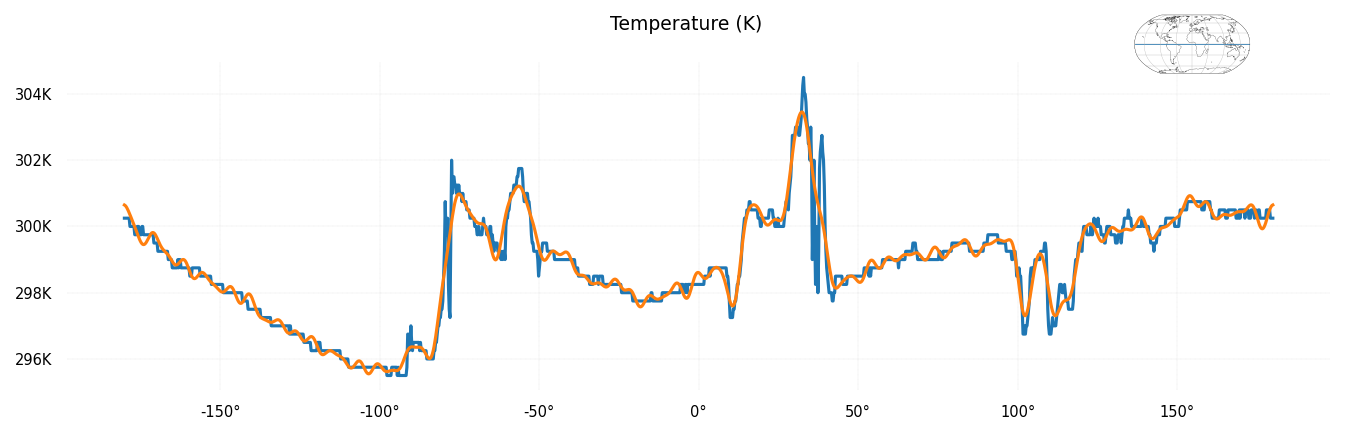


        Fourier Regression 1D:
            Data stdev: 1.5455
            MAE: 0.2083
            RMSE: 0.3399
            
            Input size: 5.62 KiBs
            Model size: 216.00 bytess
            Compression: 3.75%
            
            Frequencies: 36
            Original size: 847.04 GiBs
            Compressed size: 31.76 GiBs
        


In [124]:
idx = ["TAVG-01-01 00:00", 1000, 0]
fft = FT1D(variable[*idx], quantile=0.95)

plot = era5.plot(variable, idx)
plot.plot()
plot.plot(fft.invert())
plot.show()

fft.describe()

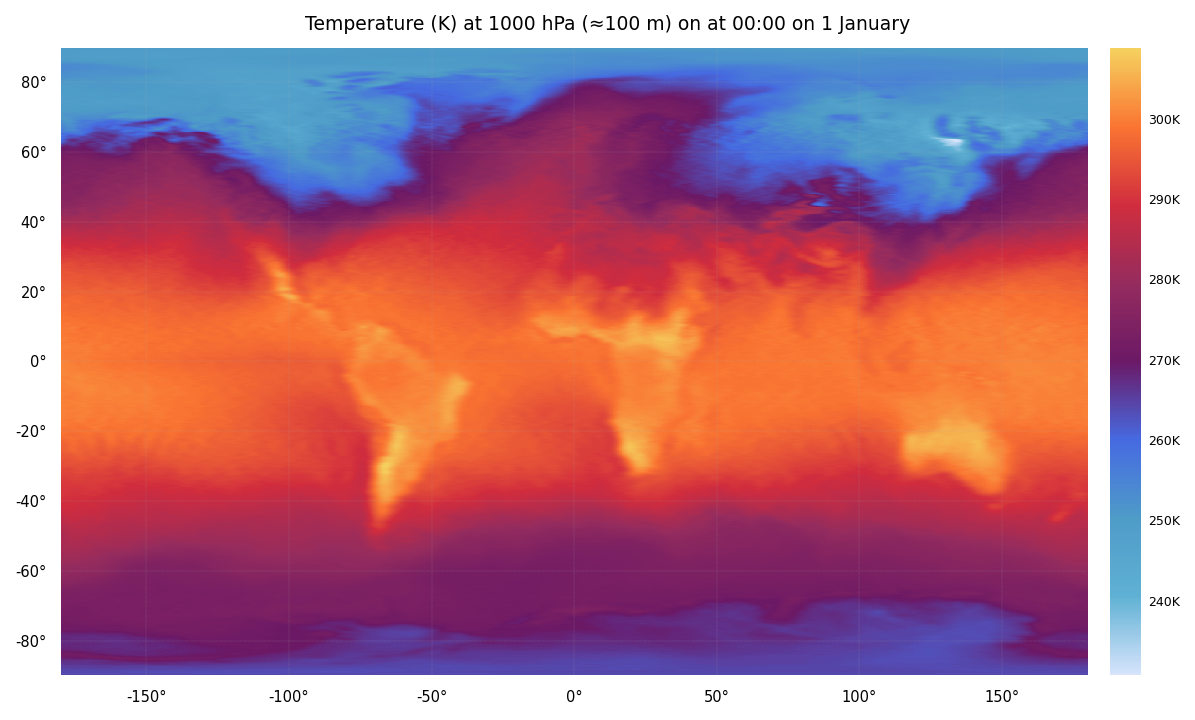

In [128]:
idx = ["TAVG-01-01 00:00", 1000]
prediction = []

for lat in np.arange(-90, 90, 0.25): 
    fft = FT1D(variable[*idx, lat], quantile=0.95)
    prediction.append(fft.invert())

plot = era5.plot(variable, idx)
plot.plot(np.array(prediction[::-1]))
plot.show()